In [167]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

from tqdm.auto import tqdm
tqdm.pandas()


In [191]:
inputs_dir = Path("/projects/rlmolecule/pstjohn/crystal_inputs/")
volrelax_dir = Path("/projects/rlmolecule/pstjohn/volume_relaxation_outputs/")

data = pd.read_pickle(Path(inputs_dir, "20220510_structures_with_scaled_inputs.p"))

vol_energy_file = Path(volrelax_dir, "20220504_volume_relaxed_energy.csv.gz")
vol_energy = pd.read_csv(vol_energy_file)

In [192]:
vol_energy['hit_upper_bound'] = vol_energy.volume > (vol_energy.dls_volume * 1.99 - 1)
vol_energy['hit_upper_bound'].sum()

7613

In [193]:
data.type.unique()

array(['icsd', 'vol', 'relax'], dtype=object)

In [194]:
to_drop = data[(data.type == 'vol') & data.id.isin(vol_energy[vol_energy['hit_upper_bound']].id)]
data_subset = data.drop(to_drop.index)

In [197]:
# vol_energy[vol_energy.hit_upper_bound]

In [200]:
import sys
sys.path.append('..')

from preprocess import preprocessor

In [201]:
def preprocess_structure(row):
    inputs = preprocessor(row.structure, train=True)

    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        warn(f"Error with {row.id}")
        return None

    scale_factor =  1.0 / inputs["distance"].min()
    inputs["distance"] *= scale_factor
    return pd.Series({"inputs": inputs, "scale_factor": scale_factor})

In [202]:
scale_factor = preprocess_structure(data.iloc[10])['scale_factor']
scale_factor

0.49448857329636925

In [203]:
struct = data.iloc[10].structure.copy()
struct.scale_lattice(data.iloc[10].structure.volume * scale_factor ** 3)
preprocessor(struct)['distance'].min()

0.99999994

In [215]:
old_vol = data.iloc[10].structure.volume
new_vol = data.iloc[10].structure.volume * scale_factor ** 3

print(old_vol, new_vol)

117.24017282470386 14.175723411330877


In [216]:
new_vol * scale_factor ** -3

117.24017282470386

In [204]:
def check_row(row):
    out = preprocess_structure(row)
    inputs = out['inputs']
    radii = np.array([site.specie.atomic_radius for site in row.structure.sites])

    r0 = radii[inputs['connectivity'][:, 0]]
    r1 = radii[inputs['connectivity'][:, 1]]
    d = inputs['distance']

    return pd.Series({
        'scaling_from_radii': (d / (r0 + r1)).min(),
        'scaling_factor': out['scale_factor'],
    })

In [205]:
sample = data_subset.sample(1000, random_state=0)

In [209]:
vol_energy[vol_energy.id.isin(sample[sample.type == 'vol'].id)].hit_upper_bound.any()

False

In [210]:
output = sample.progress_apply(check_row, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.2, 1.5)

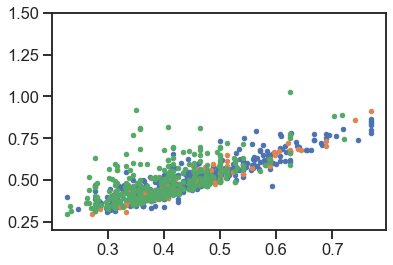

In [211]:
for type_ in sample.type.unique():
    plt.plot(output[sample.type == type_]['scaling_from_radii'], output[sample.type == type_]['scaling_factor'], '.')
    
plt.ylim([0.2, 1.5])

In [212]:
output.scaling_factor.sort_values()

20129      0.295334
3111       0.299721
8618       0.309119
41663      0.311467
43932      0.313727
            ...    
4227       0.886692
11756      0.914170
21881      0.918443
38230      1.024771
1344     459.219874
Name: scaling_factor, Length: 1000, dtype: float64

In [177]:
output.loc[43867]

scaling_from_radii    0.317460
scaling_factor        1.365744
Name: 43867, dtype: float64

In [179]:
sample.loc[43867]

id                                      Na1W1F7_sg62_icsd_072776_1
type                                                           vol
composition                                                Na1W1F7
energyperatom                                            10.053316
structure        [[6.49416165 3.11710691 1.49530918] Na, [2.715...
volume                                                  680.941719
num_sites                                                       36
inputs           {'site': [11, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9,...
Name: 43867, dtype: object

In [180]:
vol_energy[vol_energy.id == 'Na1W1F7_sg62_icsd_072776_1']

,id,comptype,num_sites,dls_volume,volume,energyperatom,hit_upper_bound
58667,Na1W1F7_sg62_icsd_072776_1,_1_1_7,36,680.941719,1361.391283,10.053316,True


In [ ]:
dls_volume 

In [118]:
struct.volume

14.175723411330871

In [95]:
data.structure.iloc[index].scale_lattice(scale_factor ** 3)

In [88]:
preprocess_structure(data.iloc[index])

inputs          {'site': [22, 22, 53, 53, 53, 53, 53, 53], 'di...
scale_factor                                             3.331643
dtype: object

In [17]:
sp.atomic_radius

1.95

In [5]:
data.dropna().drop(['structure'], axis=1)

,id,type,composition,energyperatom,volume,num_sites,inputs
0,icsd_085777,icsd,La1O1P1Zn1,-5.833295,145.053230,8,"{'site': [57, 57, 30, 30, 15, 15, 8, 8], 'dist..."
1,icsd_173786,icsd,I3Ti1,-3.397267,287.551744,8,"{'site': [22, 22, 53, 53, 53, 53, 53, 53], 'di..."
2,icsd_056827,icsd,Al2O12W3,-8.063763,1024.266060,68,"{'site': [13, 13, 13, 13, 13, 13, 13, 13, 74, ..."
3,icsd_078912,icsd,Cl9Sb1Se1,-2.729116,1208.211653,44,"{'site': [51, 51, 51, 51, 34, 34, 34, 34, 17, ..."
4,icsd_076029,icsd,P1W1,-7.874002,115.123926,8,"{'site': [15, 15, 15, 15, 74, 74, 74, 74], 'di..."
...,...,...,...,...,...,...,...
67835,Li1Sc1Cl4_sg148_icsd_095431_1,relax,Li1Sc1Cl4,-4.329067,1564.808701,36,"{'site': [21, 21, 21, 21, 21, 21, 3, 3, 3, 3, ..."
67836,K3La1F3P1_sg36_icsd_281593_3,relax,K3La1F3P1,-4.478600,1461.317455,32,"{'site': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
67837,K1Y1Sb1N3_sg62_icsd_380105_4,relax,K1Y1Sb1N3,-5.993678,461.358843,24,"{'site': [39, 39, 39, 39, 7, 7, 7, 7, 7, 7, 7,..."
67838,K3Cd1Hg1F1O3_sg29_icsd_010318_12,relax,K3Cd1Hg1F1O3,-3.647115,773.751564,36,"{'site': [9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, ..."
